# [IAPR][iapr]: Lab 1 ‒  Image segmentation


**Group ID:** xx

**Author 1 (sciper):** Student Name 1 (xxxxx)  
**Author 2 (sciper):** Student Name 2 (xxxxx)   
**Author 3 (sciper):** Student Name 3 (xxxxx)   

**Release date:** 8.03.2023  
**Due date:** 24.03.2022 (11:59 pm)


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.

[iapr]: https://github.com/LTS5/iapr

---
## 0. Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
print(data_base_path)
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')

if not os.path.exists(tar_path):
    raise Exception('Path to is not valid {}'.format(tar_path))
    
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

..\data


---
## Part 1: Segmentation


### 1.0 Intro

In this exercise, you will be given two images. 

* `mucinous_adeno.jpg`: The image depicts a tissue sample from mucinous adenocarcinoma in colorectal cancer. The data is taken from the Cancer Genome Atlas (TCGA) which is an open-source database of different cancer types. Here you can see a tissue taken from a patient and stained using hematoxylin (purple) and eosin (pink) staining. The hematoxylin stains cell nuclei with a purplish blue, and the eosin stains the extracellular matrix and cytoplasm in pink.

* `mucinous_adeno_gt.jpg`: The second image is a coarse annotation of what is regarded as the so-called mucinous area. The mucinous area can be identified as a gray area tainted with purple. The presence of a large amount of mucin is a sign of a defect of normal epithelial cells that start to produce an unreasonable amount of mucin.


### 1.1 Tasks

You will be asked to extract the mucinous area using various approaches:

- [ ] Thresholding
- [ ] Morphology
- [ ] Region growing


### 1.1 Brain image visualization

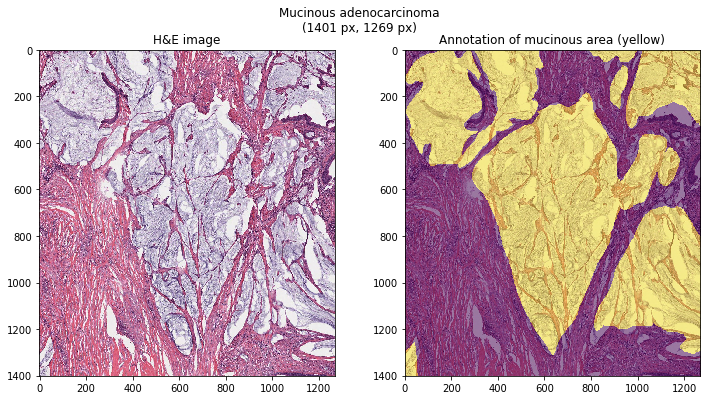

In [2]:
import skimage.io
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Load images
path_to_image = os.path.join(data_base_path, data_folder, "mucinous_adeno.jpg")
path_to_gt = os.path.join(data_base_path, data_folder, "mucinous_adeno_gt.jpg")
adeno_img = skimage.io.imread(path_to_image)
adeno_gt = skimage.io.imread(path_to_gt) > 128

# Get size of the image in px
im_h, im_w, im_c = adeno_img.shape

# Display MRI image
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot image
ax[0].imshow(adeno_img, interpolation='nearest')
ax[0].set_title('H&E image'.format(im_h, im_w))


# Plot image with overlay
ax[1].imshow(adeno_img, interpolation='nearest')
ax[1].imshow(adeno_gt, alpha=0.5, interpolation='nearest')
ax[1].set_title('Annotation of mucinous area (yellow)')

plt.suptitle("Mucinous adenocarcinoma\n({} px, {} px)".format(im_h, im_w))
plt.show()

---
### 1.2 Thresholding (4pts)
#### 1.2.1 RGB & Hue (1 pts)

Display the histogram for each channel (R, G, and B) as well as the histogram for the H (hue) channel. Note that you can use [rgb2hsv](https://scikit-image.org/docs/stable/api/skimage.color.html#skimage.color.rgb2hsv) to convert an RGB image to an HSV image and then extract the hue.

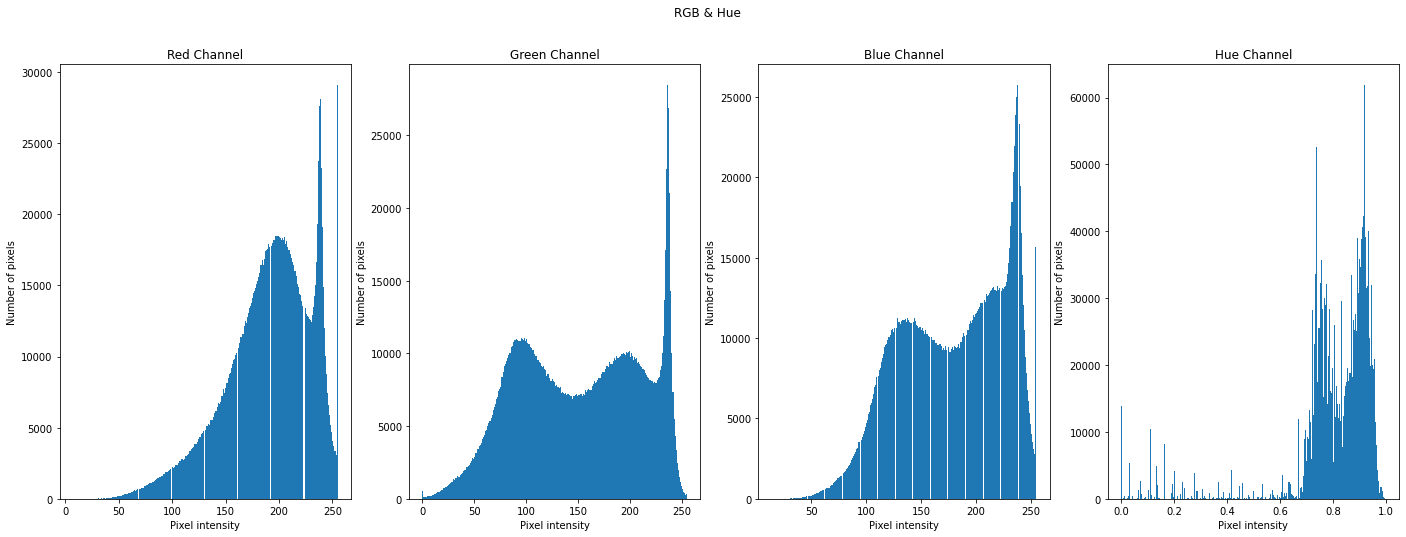

In [3]:
nb_bins = 256
# Display image
fig, ax = plt.subplots(1, 4, figsize=(24, 8))

# Red
ax[0].hist((adeno_img[:,:,0]).ravel(), bins=nb_bins)
ax[0].set(xlabel='Pixel intensity', ylabel='Number of pixels')
ax[0].set_title('Red Channel')

# Green
ax[1].hist((adeno_img[:,:,1]).ravel(), bins=nb_bins)
ax[1].set(xlabel='Pixel intensity', ylabel='Number of pixels')
ax[1].set_title('Green Channel')

# Blue
ax[2].hist((adeno_img[:,:,2]).ravel(), bins=nb_bins)
ax[2].set(xlabel='Pixel intensity', ylabel='Number of pixels')
ax[2].set_title('Blue Channel')

# Hue
adeno_hsv_img = skimage.color.rgb2hsv(adeno_img)
ax[3].hist((adeno_hsv_img[:,:,0]).ravel(), bins=nb_bins)
ax[3].set(xlabel='Pixel intensity', ylabel='Number of pixels')
ax[3].set_title('Hue Channel')


plt.suptitle("RGB & Hue")
plt.show()



#### 1.2.2 Apply Thresholding (2 pts)

For each histogram find the threshold(s) that work the best to isolate the mucinous area. Display the image after thresholding of each channel as well as the error between your prediction ($im$) and the annotations ($gt$) using the formula:

$$error = 1 - \left( \frac{1}{IJ} \sum_{i,j} im_{i,j} == gt_{i, j} \right)$$

Here, I and J are the dimension of the image.

Red Error:  0.489883675343909
Green Error:  0.26292825849373613
Blue Error:  0.29083751390006807
Hue Error:  0.19231731921755768


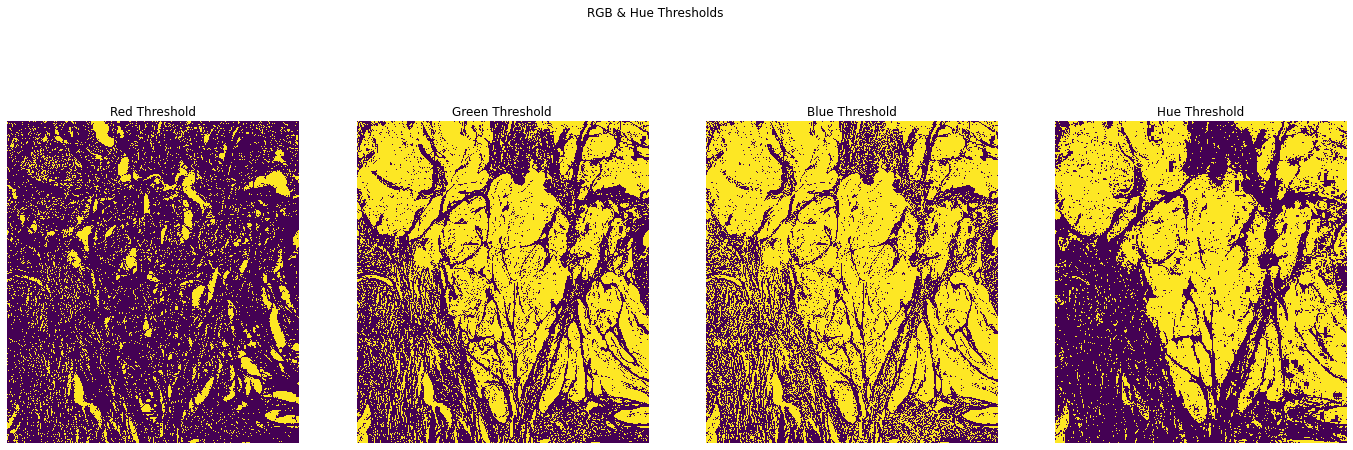

In [4]:
red_th = 230
green_th = 140
blue_th = 160
hue_th = 0.85

adeno_red_th = np.zeros((im_h, im_w))
adeno_green_th = np.zeros((im_h, im_w))
adeno_blue_th = np.zeros((im_h, im_w))
adeno_hue_th = np.zeros((im_h, im_w))
for i in range(im_h):
    for j in range(im_w):
        if (adeno_img[i,j,0] > red_th):
            adeno_red_th[i,j] = 1
        if (adeno_img[i,j,1] > green_th):
            adeno_green_th[i,j] = 1
        if (adeno_img[i,j,2] > blue_th):
            adeno_blue_th[i,j] = 1
        if (adeno_hsv_img[i,j,0] < hue_th):
            adeno_hue_th[i,j] = 1

fig, ax = plt.subplots(1, 4, figsize=(24, 8))

def get_error(image):
    error = 1 - ((1/(im_w*im_h))*np.sum(image==adeno_gt))
    return error

red_err = get_error(adeno_red_th)
green_err = get_error(adeno_green_th)
blue_err = get_error(adeno_blue_th)
hue_err = get_error(adeno_hue_th)
print("Red Error: ",red_err)
print("Green Error: ",green_err)
print("Blue Error: ",blue_err)
print("Hue Error: ",hue_err)


# Red
ax[0].imshow(adeno_red_th, interpolation='nearest')
ax[0].set_title('Red Threshold')
ax[0].axis('off')

# Green
ax[1].imshow(adeno_green_th, interpolation='nearest')
ax[1].set_title('Green Threshold')
ax[1].axis('off')

# Blue
ax[2].imshow(adeno_blue_th, interpolation='nearest')
ax[2].set_title('Blue Threshold')
ax[2].axis('off')

# Hue
ax[3].imshow(adeno_hue_th, interpolation='nearest')
ax[3].set_title('Hue Threshold')
ax[3].axis('off')


plt.suptitle("RGB & Hue Thresholds")
plt.show()





#### 1.2.3 Best Thresholding (1 pts)

Based on your previous findings, set the best threshold(s) and create the final mask as the variable `mask_thesholding`

In [5]:
# TODO: replace variable with your own threshold
mask_thresholding = adeno_hue_th

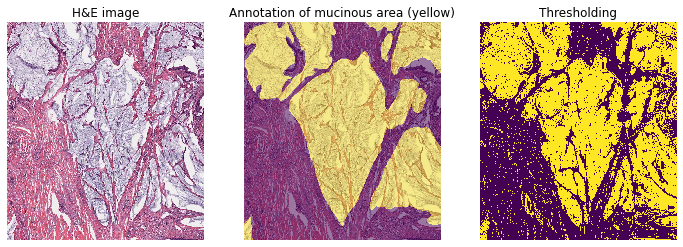

In [6]:
# Display MRI image
fig, ax = plt.subplots(1, 3, figsize=(12, 5))

# Plot image
ax[0].imshow(adeno_img, interpolation='nearest')
ax[0].set_title('H&E image'.format(im_h, im_w))
ax[0].axis('off')

ax[1].imshow(adeno_img, interpolation='nearest')
ax[1].imshow(adeno_gt, alpha=0.5, interpolation='nearest')
ax[1].set_title('Annotation of mucinous area (yellow)')
ax[1].axis('off')

ax[2].imshow(mask_thresholding, interpolation='nearest')
ax[2].imshow(mask_thresholding, alpha=0.5, interpolation='nearest')
ax[2].set_title('Thresholding')
ax[2].axis('off')

plt.show()

---

### 1.3 Morphology (5pts)

To proceed, use the best results of the previous model (namely `mask_thesholding`) as the starting point. In this exercise we will try to clean the mask using morphology.

* A (2pts): Try the following operation [closing](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.closing), [opening](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.opening) with [disk](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.disk) size of: $1, 2, 5, 10$. Comment on the quality of the results.

* B (2pts): Try the following operation [remove_small_holes](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.remove_small_holes), [remove_small_objects](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.remove_small_objects) with size of: $10, 50, 100, 500$. Comment on the quality of the results.

* C (1pts): Based on your previous results, can you find a combination of the functions that improve your results? Plot the best result along with the error rate. Save the mask as the variable `mask_morph`

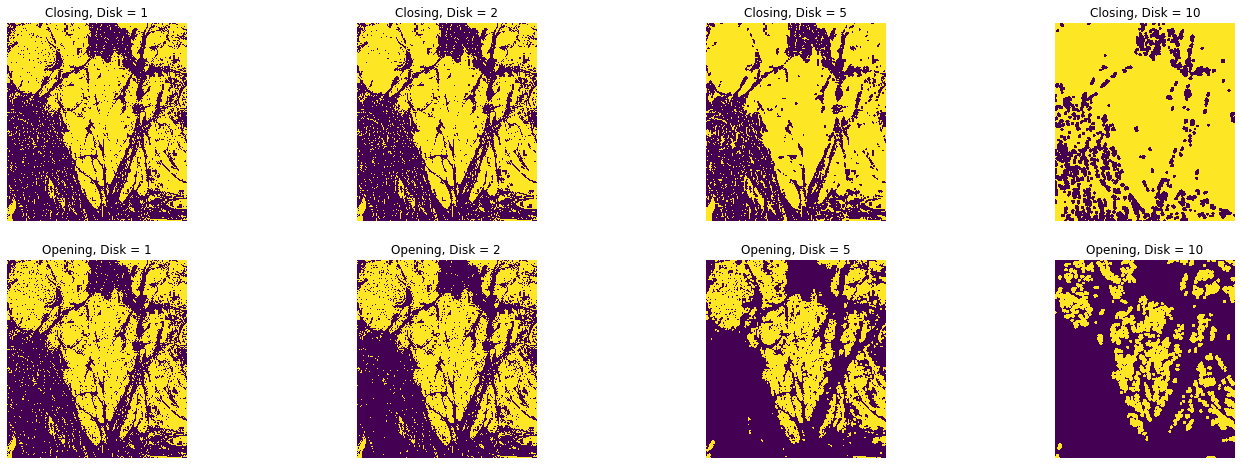

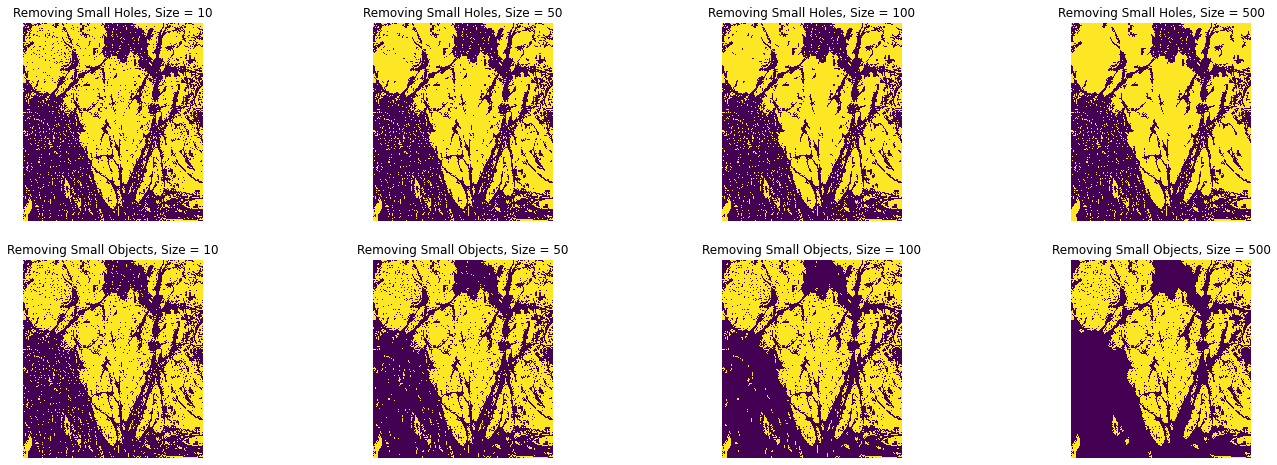

In [7]:
# TODO 
import skimage.morphology

# A

radii = [1, 2, 5, 10]
fig, ax = plt.subplots(2, len(radii), figsize=(24, 8))
for i in range(len(radii)):

    # generating disk
    disk_value = skimage.morphology.disk(radii[i])

    # performing opening and closing 
    closed = skimage.morphology.closing(mask_thresholding, disk_value)
    opened = skimage.morphology.opening(mask_thresholding, disk_value)

    # plotting
    ax[0,i].imshow(closed, interpolation='nearest')
    ax[0,i].set_title('Closing, Disk = ' + str(radii[i]))
    ax[0,i].axis('off')

    ax[1,i].imshow(opened, interpolation='nearest')
    ax[1,i].set_title('Opening, Disk = ' + str(radii[i]))
    ax[1,i].axis('off')

plt.show()

# B

sizes = [10, 50, 100, 500]
fig, ax = plt.subplots(2, len(sizes), figsize=(24, 8))
for i in range(len(sizes)):

    # performing remove_small_holes and remove_small_objects functions
    # must be type bool
    removed_holes = skimage.morphology.remove_small_holes(mask_thresholding.astype(bool), sizes[i])
    removed_objects = skimage.morphology.remove_small_objects(mask_thresholding.astype(bool), sizes[i])

    # plotting
    ax[0,i].imshow(removed_holes, interpolation='nearest')
    ax[0,i].set_title('Removing Small Holes, Size = ' + str(sizes[i]))
    ax[0,i].axis('off')

    ax[1,i].imshow(removed_objects, interpolation='nearest')
    ax[1,i].set_title('Removing Small Objects, Size = ' + str(sizes[i]))
    ax[1,i].axis('off')

plt.show()

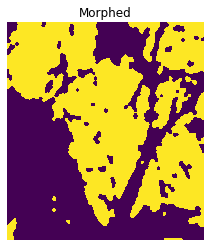

Morphology Error:  0.10999348095950834


In [8]:
# C

# creating different disk sizes
disk_1 = skimage.morphology.disk(1)
disk_5 = skimage.morphology.disk(5)
disk_10 = skimage.morphology.disk(10)
size = 500

# morphology functions
adeno_1 = skimage.morphology.closing(mask_thresholding, disk_1) 
adeno_2 = skimage.morphology.remove_small_objects(adeno_1.astype(bool), size) # removing small artifacts in hue image
adeno_3 = skimage.morphology.remove_small_holes(adeno_2.astype(bool), size) # fills the spaces in the mask
adeno_4 = skimage.morphology.opening(adeno_3, disk_10) # removing larger artifacts
adeno_5 = skimage.morphology.closing(adeno_4, disk_10) # filling remaining holes

# plotting
plt.imshow(adeno_5, interpolation='nearest')
plt.title('Morphed')
plt.axis('off')
plt.show()

mask_morph = adeno_5

#
morph_err = get_error(mask_morph)
print("Morphology Error: ", morph_err)

---
### 1.4 Region growing (5pts)

In this exercise you will implement from scratch your own region growing algorithm. Choose one of the image channel (R/G/B/H) as the source image. You can use multiple seed point to achieve better results. Plot the best result along with the error rate. Save the mask as the variable `mask_region`.

In [9]:
# TODO

# selecting hue channel as source
source = adeno_hsv_img[:,:,0]
threshold = 0.85
mask_region = np.zeros_like(source)

# creating a neighbourhood of all pixels
neighbourhood = []
for x in range(im_h):
    for y in range(im_w):
        neighbourhood.append((x, y))

# using a set for faster processing
neighbourhood = set(neighbourhood)

def get_neighbours(seed, neighbor_radius=10):

    # Parameters:
    # - seed value - pixel that wee need the neighbours of
    # - neighbor_radius - radius to consider

    # Returns:
    # - neighbours - list of pixel points within the given radius

    neighbours = []
    
    for i in range (-neighbor_radius, neighbor_radius+1):  
        for j in range(-neighbor_radius, neighbor_radius+1):
            if i == 0 and j == 0:
                continue
            neighbours.append((seed[0] + i, seed[1] + j))

    return neighbours


# choosing seeds based on the hue image
new_seeds = [(700,700), (200,200), (1200,1000)]


while True: 
    
    # assigning seeds to the new seeds
    seeds = new_seeds
    new_seeds = []
    prev_len = len(neighbourhood)
    for seed in seeds:

        # check if pixel has been examined
        if seed in neighbourhood:
            # check if pixel is below threshold
            if source[seed[0], seed[1]] < threshold:
                value = 1

                # assigning seed a value of 1 in the mask
                mask_region[seed[0], seed[1]] = value
                neighbours = get_neighbours(seed, 10)
                neighbourhood.remove(seed)
                for neighbour in neighbours:
                    if neighbour in neighbourhood:
                        mask_region[neighbour[0], neighbour[1]] = value
                  

                # selecting new seeds a distance k away from the original seed
                k = 7
                new_seeds.append((seed[0]+k, seed[1]))
                new_seeds.append((seed[0]-k, seed[1]))
                new_seeds.append((seed[0], seed[1]+k))
                new_seeds.append((seed[0], seed[1]-k))
                new_seeds.append((seed[0]+k, seed[1]+k))
                new_seeds.append((seed[0]+k, seed[1]-k))
                new_seeds.append((seed[0]-k, seed[1]+k))
                new_seeds.append((seed[0]-k, seed[1]-k))
   
    if len(neighbourhood) == prev_len:
        break

---
### 1.5 Method comparison (1pt)

In this section we display the overall outputs. Please make sure that you create the variables `mask_thesholding`, `mask_morph`, and `mask_region` to properly display the output. Comment on the results and what you think would be the best approach.

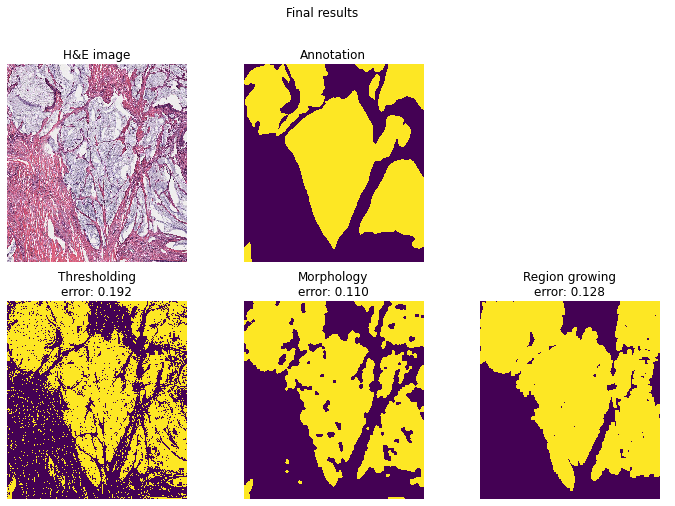

In [11]:
error_th = 1- (mask_thresholding == adeno_gt).mean()
error_morph = 1- (mask_morph == adeno_gt).mean()
error_region = 1- (mask_region == adeno_gt).mean()


# Display MRI image
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

# Plot image
ax[0, 0].imshow(adeno_img, interpolation='nearest')
ax[0, 0].set_title('H&E image'.format(im_h, im_w))

# Plot image with overlay
ax[0, 1].imshow(adeno_gt, interpolation='nearest')
ax[0, 1].set_title('Annotation')

# Plot estimation using thresholding
ax[1, 0].imshow(mask_thresholding, interpolation='nearest')
ax[1, 0].set_title('Thresholding\nerror: {:.3f}'.format(error_th))

# Plot estimation using Contour detection
ax[1, 1].imshow(mask_morph, interpolation='nearest')
ax[1, 1].set_title('Morphology\nerror: {:.3f}'.format(error_morph))


# Plot estimation using Region growing
ax[1, 2].imshow(mask_region, interpolation='nearest')
ax[1, 2].set_title('Region growing\nerror: {:.3f}'.format(error_region))


[a.axis('off') for a in ax.ravel()]


plt.suptitle("Final results")
plt.show()

The Thresholding method is the simplest of the three methods, however, the error is quite high at 19.2 %. The Morphology method has the best results, with an error of 11.0 %. However, this method is seems to be very specific to the source image and the error value would likely be higher for different images in the same context. The Region growing method also has a low error value of 12.8 % and i sless image specific than the Morphology method. A key point to note in the Region growing method is that the size of the neighbourhood matters in the algorithm as it changes the shape of the region. 

The best approach would be the Region growing method as it is the most versatile of the 3 methods with an acceptably low error rate. 

# ---
## Part 2: Axon segmentations (10 points)

#### Intro 

Axon segmentation is vital to neuroscience research as it enables the study of neurons' morphology and connectivity. We will conduct two exercises to evaluate the impact of your segmentation algorithms under different independent artefacts. Each exercise consists of a synthetic **Ground Truth (GT)** and two more images simulating a specific artifact.

The **Ground Truth**  has tree main compartments. 1) The inner part of the axon. 2) The outer layer of the axon (called myelin) and the extracellular slace (the background of the image). 

The task consists into segmenting the three main compartments in the image to compute the inner-axon and outer-axon radii distribution.


To compute the radii, we suggest the following approximation.
$$\hat{r}_{I}= \sqrt{\frac{A_{yellow}}{\pi}}$$
$$\hat{r}_{O}= \sqrt{\frac{A_{yellow} + A_{blue}}{\pi}}$$
Where **A** is the corresponding area of the comparments. 
**Using this image as reference** 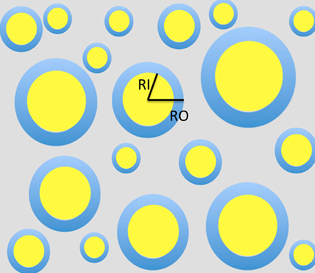

#### Artifacts simulated:

Excercise 1) Two images with different levels of SNR (signal to noise ratio). The images have rician noise.
Exercise  2) Two images adquired using a fraction of the fourier space. Only Lowest frequency are used to reconstruct the image. (simulating fast aquisitions in MRI)

Ensure your algorithm works on the GT before you go to the test cases with artifacts. Apply any preprocessing needed to the image. The preprocessing can be different for each type of image.

### Tasks

For each exercise we ask to:

1) Segment the images with the following colors: blue the inner part of the axon, red the outer part of the axon (myelin) and white for the backround(example) 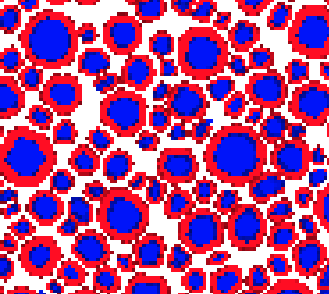

2) Count the number of axons obtained in the sample, calculate the radii for each axons, and display a radii histogram for the each of the images(GT and test cases).

In the exercises, assume that each pixel side is $(0.1 \mu m)$, i.e. a pixel has an area of $(0.01 \mu m^2 )$

## Grading 
The answers does not have to be perfect, they just be a good approximation.

1. Developing an algorithm that works for the two GT images. **(3 points)** 
2. Use preprosesing to prepare the images with SNR and the Low frequencies.  (**1 point** for SNR preprocesing , **1 point** for Low-frequency images preprocesing)
3. Running the algorithm in the test images. **1/2 point** SNR, **1/2 point** Low freqs
4. Computing and plotting radii distributions **(1 point)**
5. Explaining and discussing your implementation. **(3 points )**
    Try to be specific, not necessarily long. In the discussion include:
 1. What worked? 
 2. What did not work?
 3. Why do you think it does not work? 
 4. How could you improve your algorithms as future work?  Try to avoid general comments like "using deep learning" 
 
**Extra points: Real data example (3 points), the algorithm should display a _good enough_ segmentation.**

### 2.1 SNR

In [12]:
data_base_path

'..\\data'

..\data


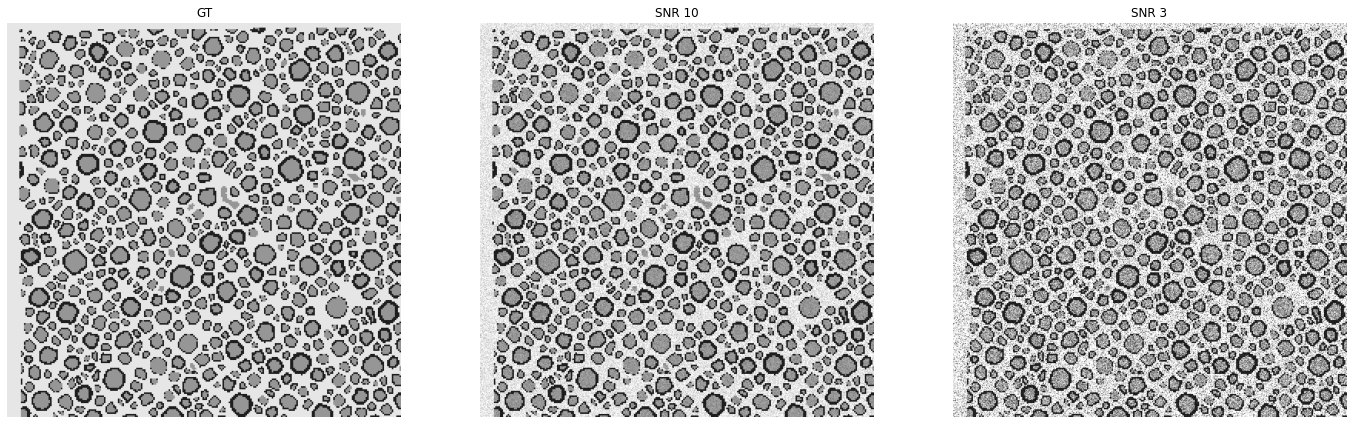

In [13]:
import cv2
import matplotlib.pyplot as plt

data_base_path = os.path.join(os.pardir, 'data')
print(data_base_path)
data_folder = 'lab-01-data'

path_folder = os.path.join(data_base_path, data_folder) + '/' 

files = ["GT_0.png"  , "test_0_0.png" , "test_0_1.png"]
gt_0 = cv2.imread(path_folder+ files[0])
snr_10 = cv2.imread(path_folder+ files[1])
snr_3 = cv2.imread(path_folder+ files[2])

images = [gt_0 , snr_10, snr_3]
im_names = ["GT" , "SNR 10" , "SNR 3"]
fig, axes = plt.subplots(1, 3, figsize=(24, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im[0:512,0:512])
    ax.axis('off')
    ax.set_title(nm)
plt.show()

In [14]:
from sklearn.mixture import GaussianMixture

def gaussian(x, mu, sig):
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

def gaussin_intersection(m1,m2,std1,std2):
  a = 1/(2*std1**2) - 1/(2*std2**2)
  b = m2/(std2**2) - m1/(std1**2)
  c = m1**2 /(2*std1**2) - m2**2 / (2*std2**2) - np.log(std2/std1)
  return np.roots([a,b,c])


def segment_axons(image):
    gray = skimage.color.rgb2gray(image)
    H = cv2.calcHist([image],[0],None,[256],[0,256])
    X = []
    for i in range(len(H)):
        X += [i] * int(H[i])
    X = np.array(X).reshape(-1,1)
    gm = GaussianMixture(n_components=3).fit(X)

    means = np.argsort((gm.means_).T)
    m0 = float(gm.means_[means[0,0]])
    std0 = float(np.sqrt(gm.covariances_[means[0,0]]))
    m1 = float(gm.means_[means[0,1]])
    std1 = float(np.sqrt(gm.covariances_[means[0,1]]))
    m2 = float(gm.means_[means[0,2]])
    std2 = float(np.sqrt(gm.covariances_[means[0,2]]))

    background_threshold = np.max(gaussin_intersection(m1, m2, std1, std2))
    if background_threshold > 255:
        background_threshold = np.min(gaussin_intersection(m1, m2, std1, std2))
    outer_axon_threshold = np.max(gaussin_intersection(m0, m1, std0, std1))
    if outer_axon_threshold > 255:
        outer_axon_threshold = np.min(gaussin_intersection(m0, m1, std0, std1))
 
    background = np.zeros_like(image)
    inner_axon = np.zeros_like(image)
    outer_axon = np.zeros_like(image)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i,j,0] > background_threshold:
                background[i,j,:] = [1,1,1]
            if image[i,j,0] < outer_axon_threshold:
                outer_axon[i,j,:] = [1,0,0]
            if image[i,j,0] < background_threshold and image[i,j,0] > outer_axon_threshold:
                inner_axon[i,j,:] = [0,0,1]
    
    disk = skimage.morphology.disk(2)
    inner_axon[:,:,2] = skimage.morphology.opening(inner_axon[:,:,2], disk)
    outer_axon[:,:,0] = skimage.morphology.remove_small_objects(outer_axon[:,:,0].astype(bool), 2)
    
    inner_axon = inner_axon*255
    outer_axon = outer_axon*255
    background = background*255
    segmented = background + inner_axon + outer_axon

    images = [image, background, inner_axon, outer_axon, segmented]

    im_names = ["GT" , "Background" , "Inner", "Outer", "Segmentation"]
    fig, axes = plt.subplots(1, 5, figsize=(24, 12))
    
    for ax, im, nm in zip(axes.ravel(), images, im_names):
        ax.imshow(im[0:512,0:512], interpolation='nearest')
        ax.axis('off')
        ax.set_title(nm)
    plt.show()
    return images

def axon_processing(image):
    labels, n_axons = skimage.measure.label(image, return_num=True)
    radii = np.zeros((n_axons-1,1))
    for i in range(n_axons):
        k = labels[labels==i].shape[0]
        area = k*0.01
        if i != 0:
            radii[i-1] = np.sqrt(area/np.pi)
    return n_axons, radii




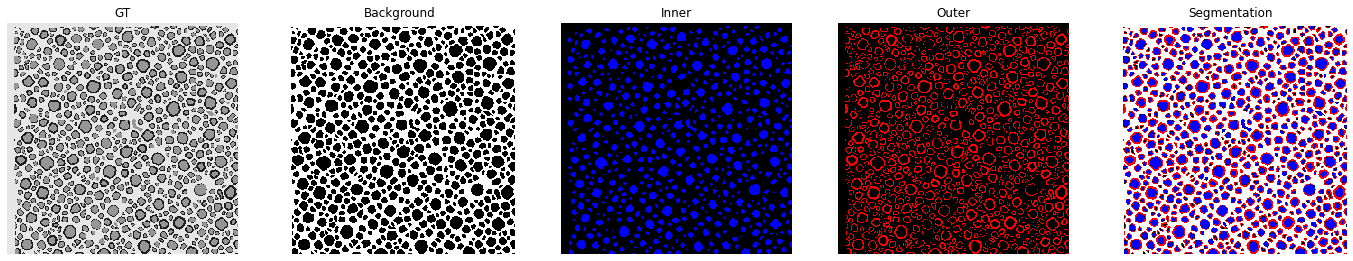

2377


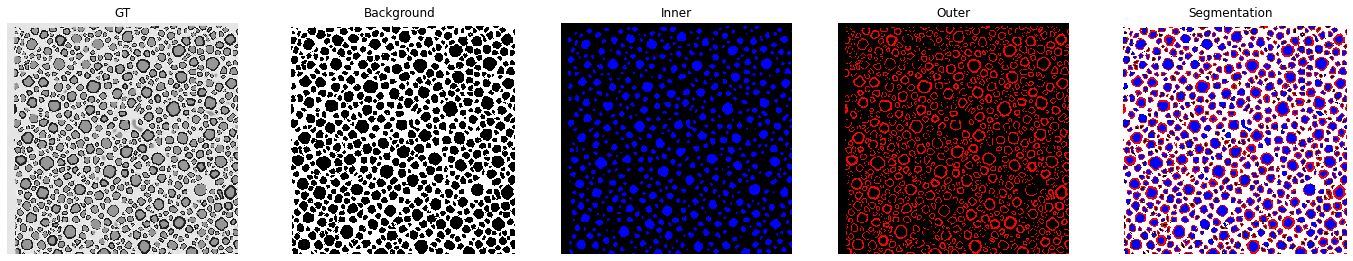

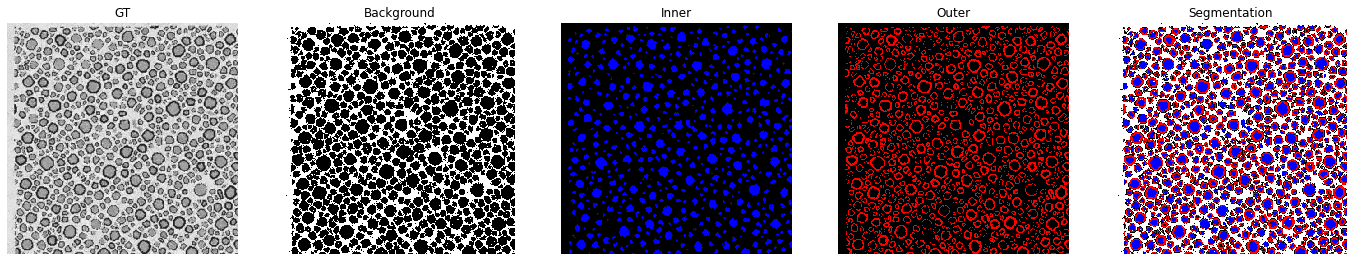

In [15]:
#### GT

gt_images = segment_axons(gt_0)
n_axons_inner_gt, inner_radii_gt = axon_processing(gt_images[2])
print(n_axons_inner_gt)

outer_axon = np.abs(gt_images[1] - 255)
n_axons_outer_gt, outer_radii_gt = axon_processing(outer_axon)

#### SNR 10 

snr_10_preprocessed = cv2.fastNlMeansDenoising(snr_10, None, 30) 
snr_10_images = segment_axons(snr_10_preprocessed)

n_axons_inner_snr10, inner_radii_snr10 = axon_processing(snr_10_images[2])

outer_axon = np.abs(snr_10_images[1] - 255)
n_axons_outer_snr10, outer_radii_snr10 = axon_processing(outer_axon)

#### SNR 3

snr_3_preprocessed = cv2.fastNlMeansDenoising(snr_3, None, 30) 
snr_3_preprocessed = cv2.GaussianBlur(snr_3_preprocessed,(3,3), 0)
snr_3_images = segment_axons(snr_3_preprocessed)

n_axons_inner_snr3, inner_radii_snr3 = axon_processing(snr_3_images[2])

outer_axon = np.abs(snr_3_images[1] - 255)
n_axons_outer_snr3, outer_radii_snr3 = axon_processing(outer_axon)


### 2.1.1 Preprocessing 

 % add your images after preprocessing


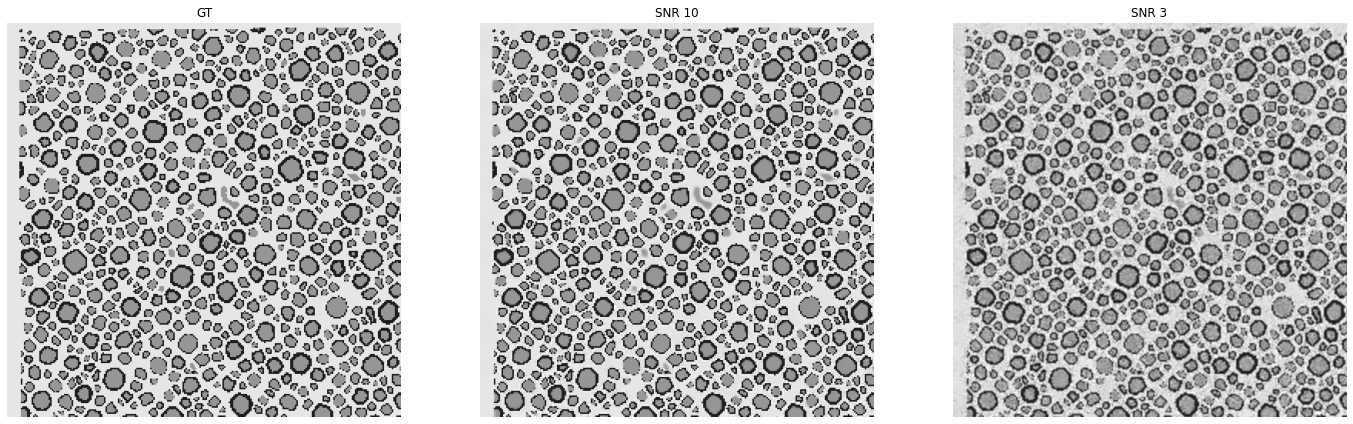

In [16]:
images = [gt_0 , snr_10_preprocessed, snr_3_preprocessed]
im_names = ["GT" , "SNR 10" , "SNR 3"]
fig, axes = plt.subplots(1, 3, figsize=(24, 24))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im[0:512,0:512])
    ax.axis('off')
    ax.set_title(nm)
plt.show()



### 2.1.2 Results Segmetations

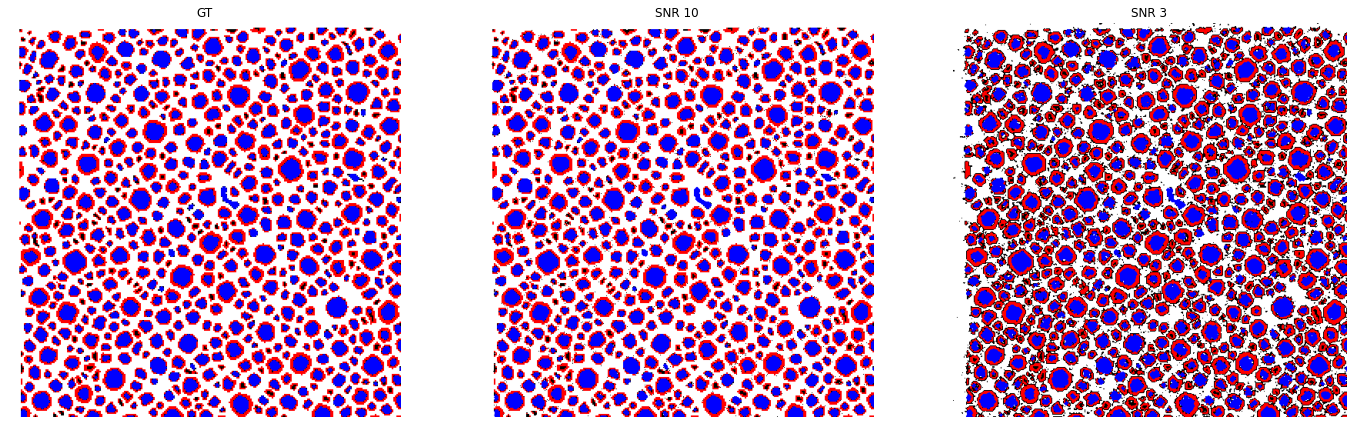

In [17]:
images = [gt_images[4] , snr_10_images[4], snr_3_images[4]]
im_names = ["GT" , "SNR 10" , "SNR 3"]
fig, axes = plt.subplots(1, 3, figsize=(24, 24))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im[0:512,0:512])
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.1.3 Radii histrograms 

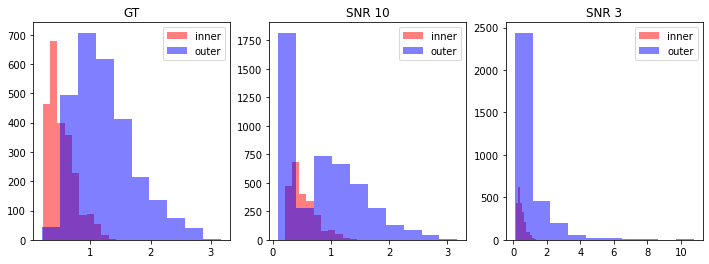

In [18]:
## results Radii distribution. proposal feel free to change it
import numpy as np


rads_outer = np.random.normal(0, 1, 200)
rads_inner = radii


rads_gt = [inner_radii_gt, outer_radii_gt]
rads_test0 = [inner_radii_snr10, outer_radii_snr10]  # your result
rads_test1 = [inner_radii_snr3, outer_radii_snr3]  # your result

all_rads= [rads_gt , rads_test0 , rads_test1] 

images = [gt_0 , snr_10, snr_3]
im_names = ["GT" , "SNR 10" , "SNR 3"]
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, rads, nm in zip(axes.ravel(), all_rads, im_names):
    ax.hist(rads[0]  , color = "red" , label = "inner" ,alpha= 0.5)
    ax.hist(rads[1]  , color = "blue" , label = "outer" ,alpha= 0.5)
    ax.legend()
    ax.set_title(nm)
plt.show()


### 2.2 Low frequencies

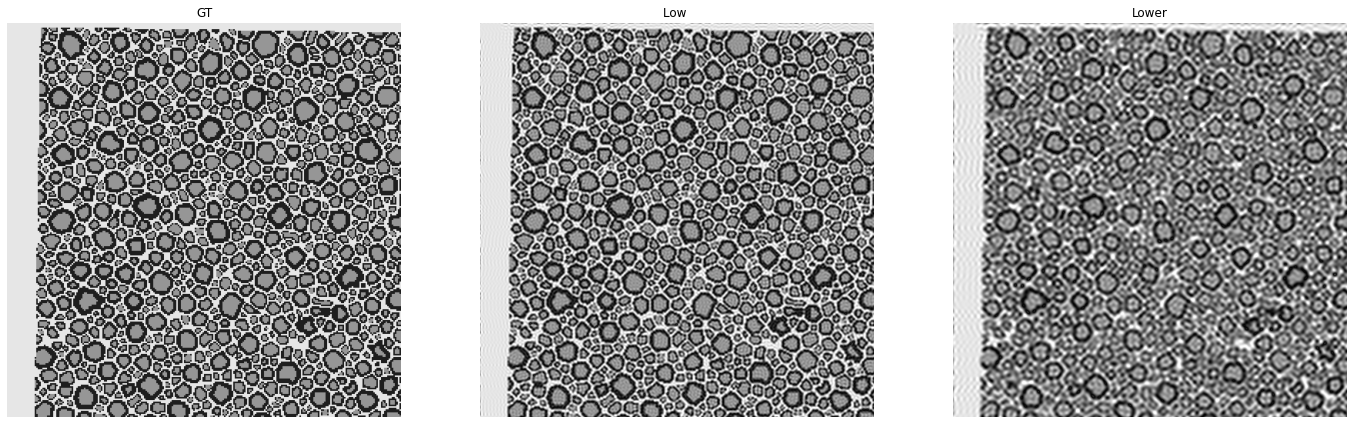

In [19]:

files = ["GT_3.png"  , "test_3_0.png" , "test_3_1.png"]
path = "data/"
gt_3 = cv2.imread(path_folder+ files[0])
lowfreq0 = cv2.imread(path_folder+ files[1])
lowfreq1 = cv2.imread(path_folder+ files[2])

images = [gt_3 , lowfreq0, lowfreq1]
im_names = ["GT" , "Low " , "Lower"]
fig, axes = plt.subplots(1, 3, figsize=(24, 24))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im[0:512,0:512])
    ax.axis('off')
    ax.set_title(nm)
plt.show()

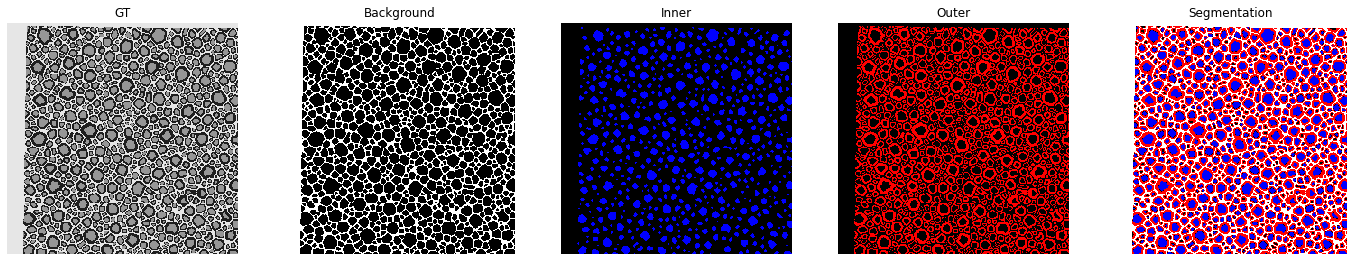

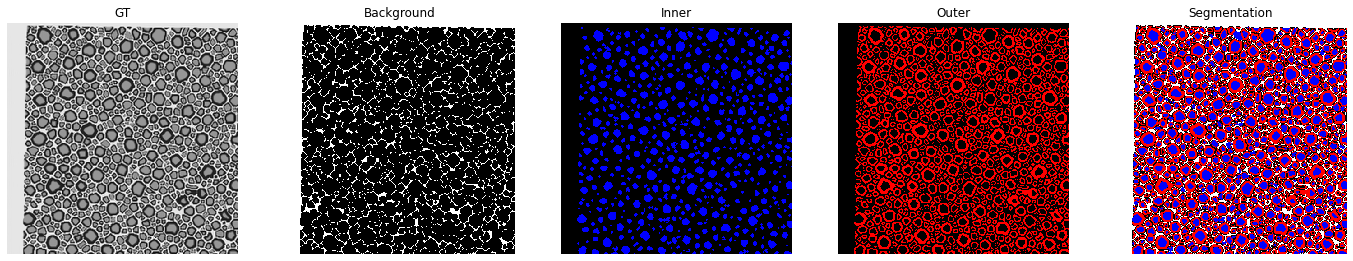

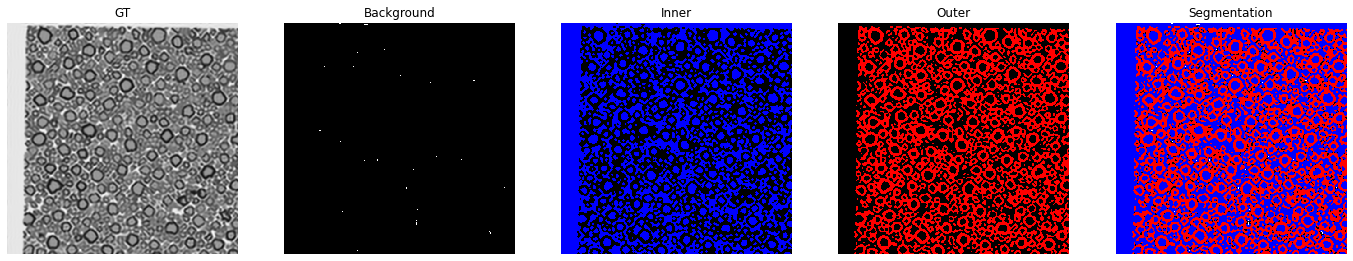

In [20]:
#### GT

gt_images = segment_axons(gt_3)
n_axons_inner_gt, inner_radii_gt = axon_processing(gt_images[2])

outer_axon = np.abs(gt_images[1] - 255)
n_axons_outer_gt, outer_radii_gt = axon_processing(outer_axon)

#### LF0

lf0_preprocessed = cv2.fastNlMeansDenoising(lowfreq0, None, 30) 
lf0_images = segment_axons(lf0_preprocessed)

n_axons_inner_lf0, inner_radii_lf0 = axon_processing(lf0_images[2])

outer_axon = np.abs(lf0_images[1] - 255)
n_axons_outer_lf0, outer_radii_lf0 = axon_processing(outer_axon)

#### LF1
lf1_preprocessed = cv2.fastNlMeansDenoising(lowfreq1, None, 30) 
lf1_preprocessed = cv2.GaussianBlur(lf1_preprocessed,(3,3), 0)
lf1_images = segment_axons(lf1_preprocessed)

n_axons_inner_lf1, inner_radii_lf1 = axon_processing(lf1_images[2])

outer_axon = np.abs(lf1_images[1] - 255)
n_axons_outer_lf1, outer_radii_lf1 = axon_processing(outer_axon)

### 2.2.1 Preprocessing


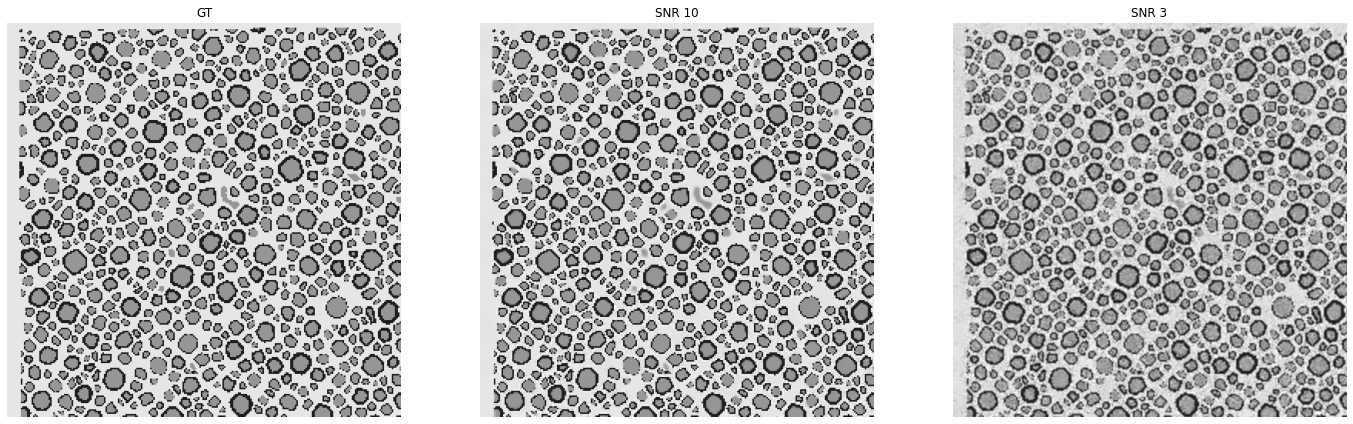

In [21]:
images = [gt_0 , snr_10_preprocessed, snr_3_preprocessed]
im_names = ["GT" , "SNR 10" , "SNR 3"]
fig, axes = plt.subplots(1, 3, figsize=(24, 24))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im[0:512,0:512])
    ax.axis('off')
    ax.set_title(nm)
plt.show()



### 2.2.2 Results Segmetations


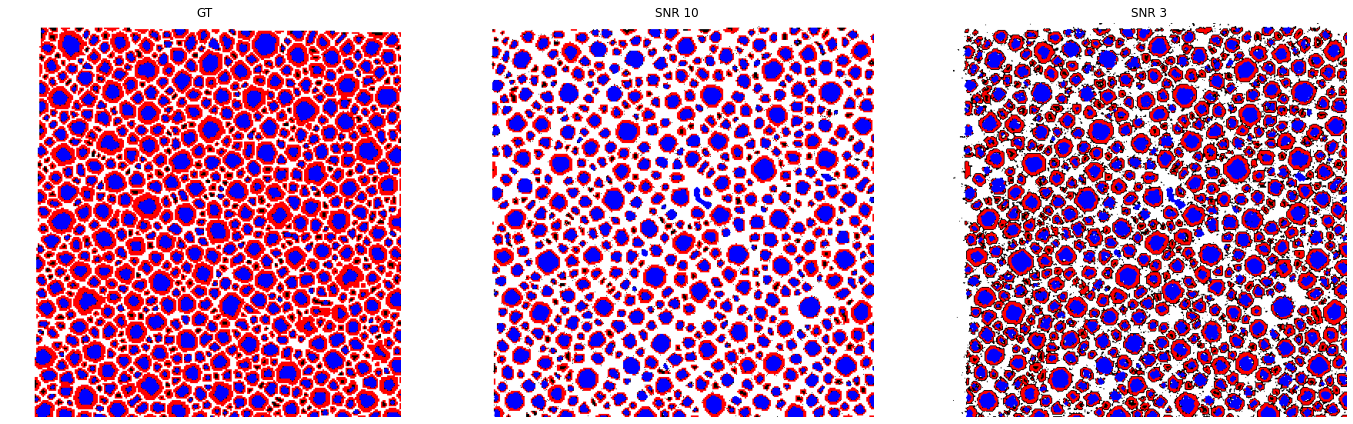

In [22]:
images = [gt_images[4] , snr_10_images[4], snr_3_images[4]]
im_names = ["GT" , "SNR 10" , "SNR 3"]
fig, axes = plt.subplots(1, 3, figsize=(24, 24))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im[0:512,0:512])
    ax.axis('off')
    ax.set_title(nm)
plt.show()


### 2.2.3 Radii histrograms


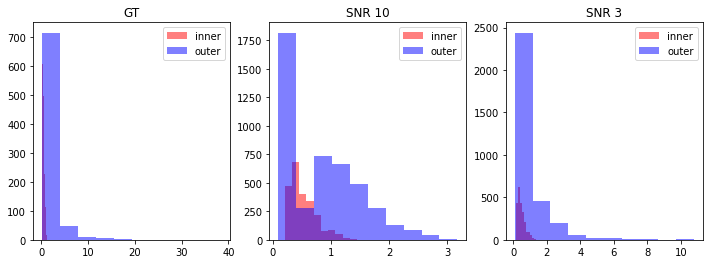

In [23]:
## results Radii distribution. proposal feel free to change it
import numpy as np


rads_outer = np.random.normal(0, 1, 200)
rads_inner = radii


rads_gt = [inner_radii_gt, outer_radii_gt]
rads_test0 = [inner_radii_snr10, outer_radii_snr10]  # your result
rads_test1 = [inner_radii_snr3, outer_radii_snr3]  # your result

all_rads= [rads_gt , rads_test0 , rads_test1] 

images = [gt_0 , snr_10, snr_3]
im_names = ["GT" , "SNR 10" , "SNR 3"]
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, rads, nm in zip(axes.ravel(), all_rads, im_names):
    ax.hist(rads[0]  , color = "red" , label = "inner" ,alpha= 0.5)
    ax.hist(rads[1]  , color = "blue" , label = "outer" ,alpha= 0.5)
    ax.legend()
    ax.set_title(nm)
plt.show()


### 2.5 Not mandatory exercise, Real data ( 3 points )

The points are given just by having a good enough segmentation.

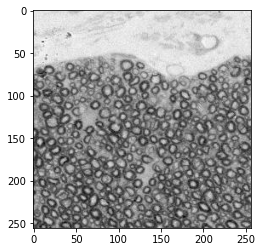

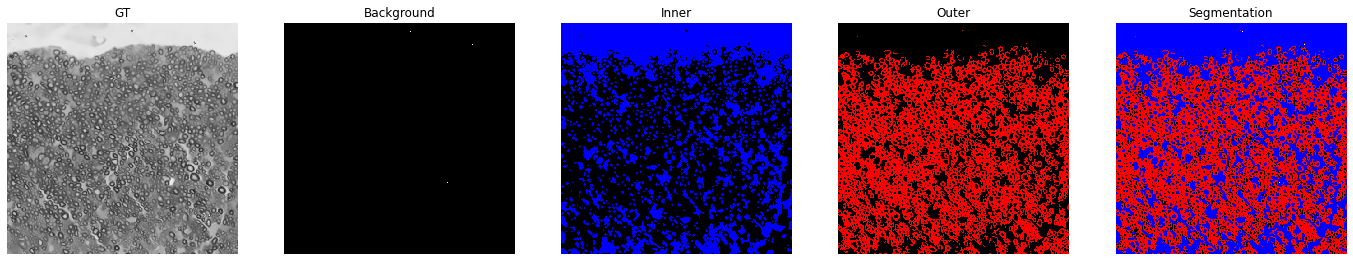

In [24]:
# Add your implementation and discussion
import cv2

files = ["extra_point.png" ]
real_data = cv2.imread(path_folder+ files[0])

plt.imshow(real_data[:256, :256])
real_data_pp = cv2.fastNlMeansDenoising(real_data, None, 20) 
# real_data_pp = cv2.GaussianBlur(real_data_pp,(3,3), 0)

images = segment_axons(real_data_pp)